<a href="https://colab.research.google.com/github/aniketjivani/generative_experiments/blob/master/vanilla_stein_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import numpy.matlib as nm

class SVGD_ll():
    """
    Low-level SVGD implementation from DartML
    """
    def __init__(self):
        pass

    def svgd_kernel(self, theta, h = -1):
        sq_dist = pdist(theta)
        pairwise_dists = squareform(sq_dist)**2
        if h < 0: # if h < 0, using median trick
            h = np.median(pairwise_dists)
            h = np.sqrt(0.5 * h / np.log(theta.shape[0]+1))

        # compute the rbf kernel
        Kxy = np.exp( -pairwise_dists / h**2 / 2)

        dxkxy = -np.matmul(Kxy, theta)
        sumkxy = np.sum(Kxy, axis=1)
        for i in range(theta.shape[1]):
            dxkxy[:, i] = dxkxy[:,i] + np.multiply(theta[:,i],sumkxy)
        dxkxy = dxkxy / (h**2)
        return (Kxy, dxkxy, h)


    def update(self, x0, lnprob,
               n_iter = 1000,
               stepsize = 1e-3,
               bandwidth = -1,
               alpha = 0.9,
               return_all = False,
               debug = False):
        # Check input
        if x0 is None or lnprob is None:
            raise ValueError('x0 or lnprob cannot be None!')

        theta_all = np.zeros((x0.shape[0], x0.shape[1], n_iter))
        lengthscales_all = np.zeros(n_iter)
        theta = np.copy(x0)

        # adagrad with momentum
        fudge_factor = 1e-6
        historical_grad = 0
        kxy_final = []
        dxkxy_final = []
        lnpgrad_final = []
        for iter in range(n_iter):
            if debug and (iter+1) % 1000 == 0:
                print('iter ' + str(iter+1))

            lnpgrad = lnprob(theta)
            # calculating the kernel matrix
            kxy, dxkxy, h = self.svgd_kernel(theta, h=-1)
            grad_theta = (np.matmul(kxy, lnpgrad) + dxkxy) / x0.shape[0]

            lengthscales_all[iter] = h

            # adagrad
            if iter == 0:
                historical_grad = historical_grad + grad_theta ** 2
            else:
                historical_grad = alpha * historical_grad + (1 - alpha) * (grad_theta ** 2)
            adj_grad = np.divide(grad_theta, fudge_factor+np.sqrt(historical_grad))
            theta = theta + stepsize * adj_grad

            theta_all[:, :, iter] = theta
            if iter == n_iter - 1:
              kxy_final = kxy
              dxkxy_final = dxkxy
              lnpgrad_final = lnpgrad
        if return_all:
          # return theta_all, lengthscales_all
          return theta_all, lengthscales_all, kxy_final, dxkxy_final, lnpgrad_final
        else:
          return theta


Example of multivariate normal implemented with above in the DartML code:

In [4]:
class MVN:
    def __init__(self, mu, A):
        self.mu = mu
        self.A = A

    def dlnprob_wrong(self, theta):
        return -1*np.matmul(theta-nm.repmat(self.mu, theta.shape[0], 1), self.A)

    def dlnprob(self, theta):
        return -1*np.matmul(theta-nm.repmat(self.mu, theta.shape[0], 1),
                            np.linalg.inv(self.A))

A = np.array([[0.2260,0.1652],[0.1652,0.6779]])
mu = np.array([-0.6871,0.8010])
model = MVN(mu, A)


x0 = np.random.normal(0,1, [200,2])
print(model.dlnprob(x0).shape)
print(SVGD_ll().svgd_kernel(x0)[0].shape)

(200, 2)
(200, 200)


In [5]:
theta1 = SVGD_ll().update(x0, model.dlnprob, n_iter=500, stepsize=0.01)
print("ground truth: ", mu)
print("svgd: ", np.mean(theta1,axis=0))
print("svgd: ", np.cov(theta1.T))

theta2 = SVGD_ll().update(x0, model.dlnprob_wrong, n_iter=500, stepsize=0.01)
print("ground truth: ", mu)
print("svgd: ", np.mean(theta2,axis=0))
print("svgd: ", np.cov(theta2.T))

ground truth:  [-0.6871  0.801 ]
svgd:  [-0.68602914  0.80008079]
svgd:  [[0.21473477 0.15535184]
 [0.15535184 0.64942491]]
ground truth:  [-0.6871  0.801 ]
svgd:  [-0.68527374  0.80115755]
svgd:  [[ 5.14499023 -1.24967528]
 [-1.24967528  1.72217686]]


In [6]:
import matplotlib.pyplot as plt

plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=150,
      #  figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)
plt.style.use("dark_background")

In [7]:
from scipy.stats import qmc

sampler = qmc.Sobol(d=2, scramble=False)
initial_particles = sampler.random(n=100)

# rescale initial points to lie within -1, 1
initial_particles = 2 * initial_particles - 1


/usr/local/lib/python3.10/dist-packages/scipy/stats/_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


In [8]:
import torch

In [9]:
class RBF(torch.nn.Module):
  def __init__(self, sigma=None):
    super(RBF, self).__init__()

    self.sigma = sigma

  def forward(self, X, Y):
    XX = X.matmul(X.t())
    XY = X.matmul(Y.t())
    YY = Y.matmul(Y.t())

    dnorm2 = -2 * XY + XX.diag().unsqueeze(1) + YY.diag().unsqueeze(0)

    # Apply the median heuristic (PyTorch does not give true median)
    if self.sigma is None:
      np_dnorm2 = dnorm2.detach().cpu().numpy()
      h = np.median(np_dnorm2) / (2 * np.log(X.size(0) + 1))
      sigma = np.sqrt(h).item()
    else:
      sigma = self.sigma

    gamma = 1.0 / (1e-8 + 2 * sigma ** 2)
    K_XY = (-gamma * dnorm2).exp()

    return K_XY

# Let us initialize a reusable instance right away.
K = RBF()

(-3.0, 3.0)

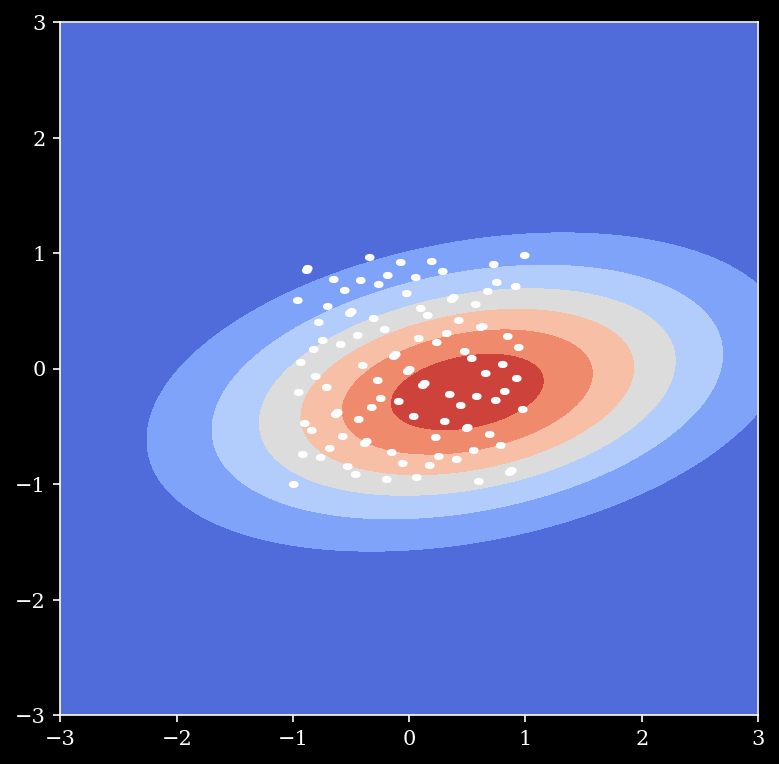

In [10]:
from scipy.stats import multivariate_normal

x, y = np.mgrid[-3:3:.01, -3:3:.01]
pos = np.dstack((x, y))

mu_oracle = np.array([0.5, -0.2])
cov_oracle = np.array([[2.0, 0.3], [0.3, 0.5]])

rv = multivariate_normal(mu_oracle, cov_oracle)


fig2 = plt.figure(figsize=(6, 6))
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y,
             rv.pdf(pos),
             cmap='coolwarm')

marker_symbol = u'\u2B2C'

# Scatter initial particles
ax2.scatter(initial_particles[:, 0], initial_particles[:, 1],
            color="white",
            marker="$%s$" % marker_symbol,
            s=15,
            clip_on=False)

ax2.set_xlim(-3, 3)
ax2.set_ylim(-3, 3)

(-3.0, 3.0)

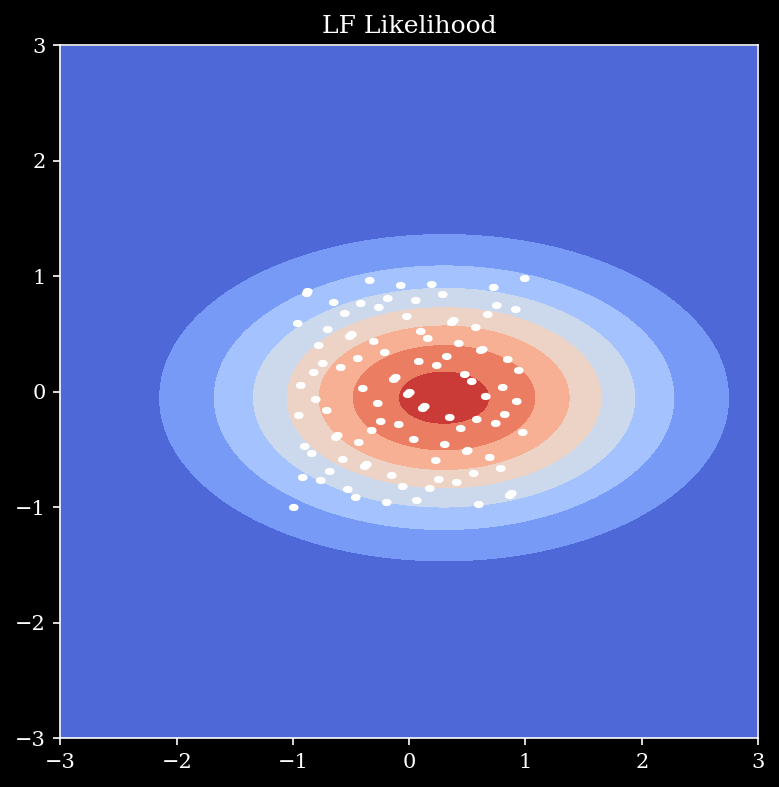

In [11]:
from scipy.stats import multivariate_normal

# x, y = np.mgrid[-3:3:.01, -3:3:.01]
# pos = np.dstack((x, y))

mu_oracle_lf = np.array([0.3, -0.05])
cov_oracle_lf = np.array([[1.5, 0.0], [0.0, 0.5]])

rv_lf = multivariate_normal(mu_oracle_lf, cov_oracle_lf)

fig2 = plt.figure(figsize=(6, 6))
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y,
             rv_lf.pdf(pos),
             cmap='coolwarm')

marker_symbol = u'\u2B2C'

# Scatter initial particles
ax2.scatter(initial_particles[:, 0], initial_particles[:, 1],
            color="white",
            marker="$%s$" % marker_symbol,
            s=15,
            clip_on=False)

ax2.set_title("LF Likelihood")
ax2.set_xlim(-3, 3)
ax2.set_ylim(-3, 3)

In [36]:
# Expression for dlogprob of multivariate normal (inefficient):
def mvn_dlnprob(theta, mu=mu_oracle, cov=cov_oracle):
    return -1*np.matmul(theta-nm.repmat(mu, theta.shape[0], 1),
                        np.linalg.inv(cov))

# single fidelity Stein
post_particles_all, lengthscales_all, kxy_samp, dxkxy_samp, lnpgrad_samp = SVGD_ll().update(initial_particles,
                                                        mvn_dlnprob,
                                                        n_iter=1500,
                                                        stepsize=0.01,
                                                        return_all=True)

# post_particles_all, lengthscales_all = SVGD_ll().update(initial_particles,
#                                                         mvn_dlnprob,
#                                                         n_iter=1500,
#                                                         stepsize=0.01,
#                                                         return_all=True)

In [37]:
kxy_samp.shape, dxkxy_samp.shape, lnpgrad_samp.shape

((100, 100), (100, 2), (100, 2))

In [13]:
post_particles_all.shape

(100, 2, 1500)

In [43]:
from sklearn.datasets import load_iris
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF as RBF_kernel
XXX, yyyy = load_iris(return_X_y=True)
XXX.shape
blah = RBF_kernel()
blah(XXX).shape

(150, 150)

(-3.0, 3.0)

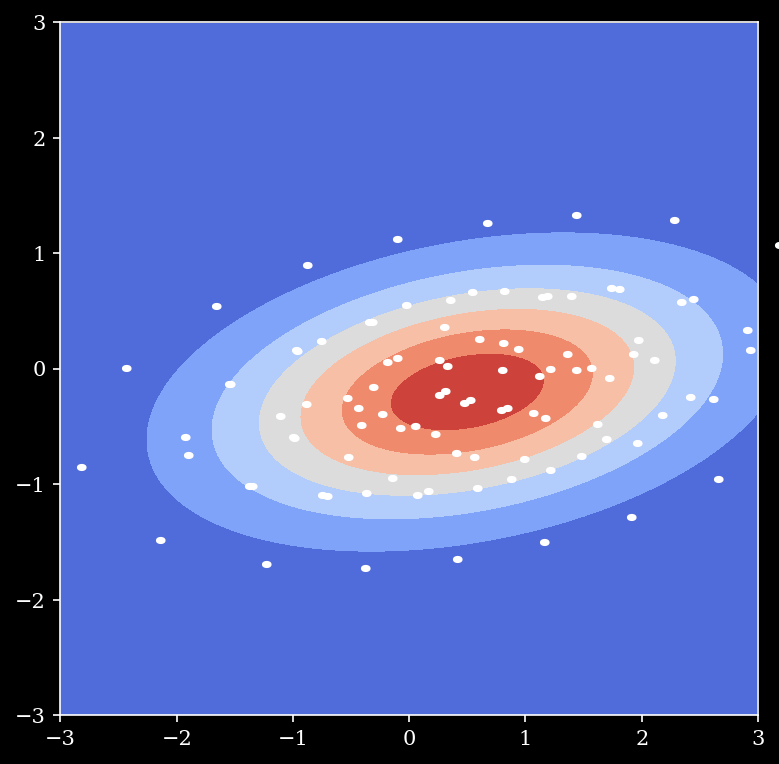

In [14]:

x, y = np.mgrid[-3:3:.01, -3:3:.01]
pos = np.dstack((x, y))

fig2 = plt.figure(figsize=(6, 6))
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y,
             rv.pdf(pos),
             cmap='coolwarm')

marker_symbol = u'\u2B2C'

# Scatter initial particles
ax2.scatter(post_particles_all[:, 0, -1], post_particles_all[:, 1, -1],
            color="white",
            marker="$%s$" % marker_symbol,
            s=15,
            clip_on=False)

ax2.set_xlim(-3, 3)
ax2.set_ylim(-3, 3)

In [15]:
lengthscales_all.shape

(1500,)

Text(0, 0.5, 'lengthscale')

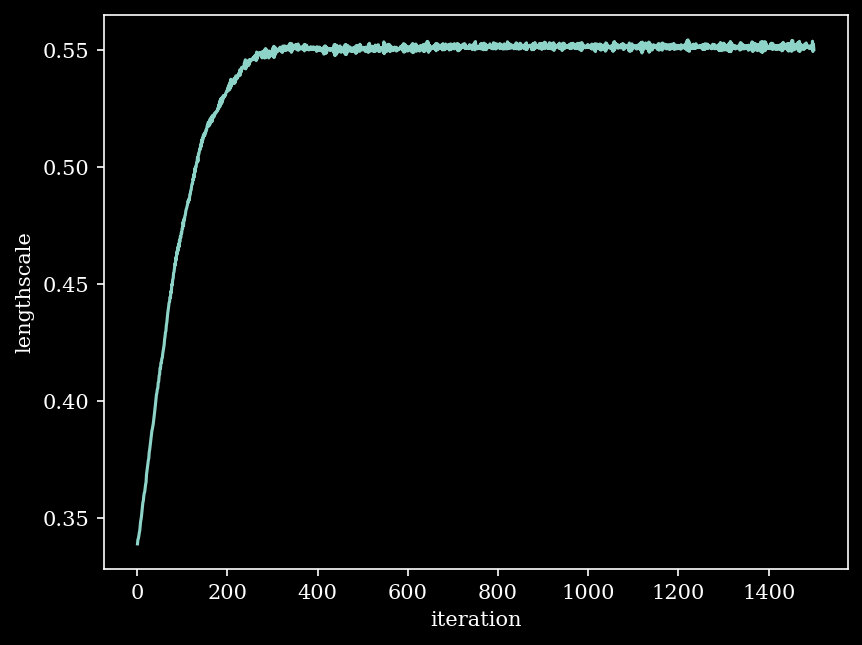

In [16]:
# plot lengthscales
n_iters = 1500
plt.plot(np.linspace(1, n_iters, n_iters), lengthscales_all)
plt.xlabel("iteration")
plt.ylabel("lengthscale")

In [17]:
# now allocate particles to different distributions:
frac_particles_lf = 0.7
n_particles_lf = int(frac_particles_lf * 100)
n_particles_hf = 100 - n_particles_lf

print(n_particles_lf, n_particles_hf)

indices_arr = np.arange(100)
np.random.shuffle(indices_arr)
print(indices_arr)
indices_all = indices_arr[:100]
indices_lf = indices_all[:n_particles_lf]
indices_hf = indices_all[n_particles_lf:]

indices_lf, indices_hf

70 30
[20 94 85 26 87 18 44 53 45 24 72 74  6 69  3 28 27 35 76 15 23 84 13  4
 38 77 31 92 46 73 36 32  9 61 34 59 55 93 70 40 98 17 54 19 51 42 30 64
  2 97 89 58 39 62 50 49 29 43  1 22 68 81 21 52  0 90 11 56 63 47 96 99
 41 79 37  5 80 91 25 65 83 10 75  7 16 48 60 95 67  8 12 57 14 66 78 71
 82 33 88 86]


(array([20, 94, 85, 26, 87, 18, 44, 53, 45, 24, 72, 74,  6, 69,  3, 28, 27,
        35, 76, 15, 23, 84, 13,  4, 38, 77, 31, 92, 46, 73, 36, 32,  9, 61,
        34, 59, 55, 93, 70, 40, 98, 17, 54, 19, 51, 42, 30, 64,  2, 97, 89,
        58, 39, 62, 50, 49, 29, 43,  1, 22, 68, 81, 21, 52,  0, 90, 11, 56,
        63, 47]),
 array([96, 99, 41, 79, 37,  5, 80, 91, 25, 65, 83, 10, 75,  7, 16, 48, 60,
        95, 67,  8, 12, 57, 14, 66, 78, 71, 82, 33, 88, 86]))

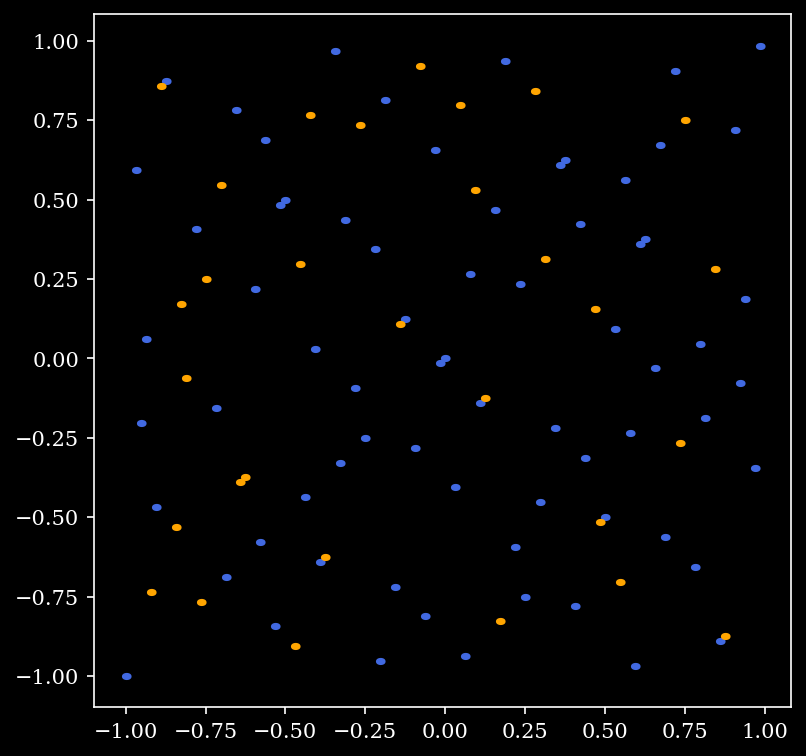

In [18]:
initial_particles_lf = initial_particles[indices_lf, :]
initial_particles_hf = initial_particles[indices_hf, :]

# plot initial particles colored by their lf-hf allocation:
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(initial_particles_lf[:, 0], initial_particles_lf[:, 1],
            color="royalblue",
            marker="$%s$" % marker_symbol,
            s=15,
            clip_on=False,
            label="low fidelity")

ax.scatter(initial_particles_hf[:, 0], initial_particles_hf[:, 1],
            color="orange",
            marker="$%s$" % marker_symbol,
            s=15,
            clip_on=False,
            label="high fidelity")


In [19]:
mu_oracle, cov_oracle

(array([ 0.5, -0.2]),
 array([[2. , 0.3],
        [0.3, 0.5]]))

In [20]:
mu_oracle_lf, cov_oracle_lf

(array([ 0.3 , -0.05]),
 array([[1.5, 0. ],
        [0. , 0.5]]))

In [21]:
# thanks stackexchange
import scipy.stats as st
from matplotlib import cm

def make_cloud(x, y, std1, std2, n=100):
    x = np.random.normal(x, std1, n)
    y = np.random.normal(y, std2, n)
    return np.array([x, y])

def contour_cloud(x, y, cmap):
    xmin, xmax = -4, 4
    ymin, ymax = -4, 4

    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)

    # plt.contourf(xx, yy, f, cmap=cmap, alpha=0.5)
    step = 0.02
    m = np.amax(f)
    levels = np.arange(0.0, m, step) + step
    plt.contourf(xx, yy, f, levels, cmap=cmap, alpha=0.5)

# cloud1 = make_cloud(0.5, -0.2, np.sqrt(2), np.sqrt(0.5))
# cloud2 = make_cloud(0.3, -0.05, np.sqrt(1.5), np.sqrt(0.5))

# plt.scatter(x=cloud1[:,0], y=cloud1[:,1])
# plt.scatter(x=cloud2[:,0], y=cloud2[:,1], color='red')

# fig = plt.gcf()
# ax = plt.gca()

# contour_cloud(x=cloud1[:, 0], y=cloud1[:, 1], cmap=cm.Blues)
# contour_cloud(x=cloud2[:, 0], y=cloud2[:, 1], cmap=cm.Reds)

In [23]:
n_iters

1500

In [24]:
# Function to do multiple fidelity updates. Add an additional argument to randomize positions after each update!!

class SVGD_multiple_fidelities_wrong():
    """
    Low-level SVGD implementation from DartML, modified to do multiple fidelity updates and
    (possibly) communicate between them! (it looks like more than anything, the communication is going to be the bottleneck)
    """
    def __init__(self):
        pass

    def svgd_kernel(self, theta, h = -1):
        sq_dist = pdist(theta)
        pairwise_dists = squareform(sq_dist)**2
        if h < 0: # if h < 0, using median trick
            h = np.median(pairwise_dists)
            h = np.sqrt(0.5 * h / np.log(theta.shape[0]+1))

        # compute the rbf kernel
        Kxy = np.exp( -pairwise_dists / h**2 / 2)

        dxkxy = -np.matmul(Kxy, theta)
        sumkxy = np.sum(Kxy, axis=1)
        for i in range(theta.shape[1]):
            dxkxy[:, i] = dxkxy[:,i] + np.multiply(theta[:,i],sumkxy)
        dxkxy = dxkxy / (h**2)
        return (Kxy, dxkxy, h)


    def update(self, x0, lnprob_hf,
               lnprob_lf,
               indices_hf,
               indices_lf,
               n_iters = 1000,
               stepsize = 1e-3,
               bandwidth = -1,
               alpha = 0.9,
               return_all = False,
               debug = False):
        # Check input
        if x0 is None or lnprob_lf is None or lnprob_hf is None:
            raise ValueError('x0 or lnprobs cannot be None!')

        lf_particles = x0[indices_lf, :]
        hf_particles = x0[indices_hf, :]

        theta_all_lf = np.zeros((lf_particles.shape[0], lf_particles.shape[1], n_iters))
        theta_all_hf = np.zeros((hf_particles.shape[0], hf_particles.shape[1], n_iters))



        lengthscales_all_lf = np.zeros(n_iters)
        lengthscales_all_hf = np.zeros(n_iters)

        theta_lf = np.copy(lf_particles)
        theta_hf = np.copy(hf_particles)

        # adagrad with momentum
        fudge_factor = 1e-6
        historical_grad_lf = 0
        historical_grad_hf = 0
        for iter in range(n_iters):
            if debug and (iter+1) % 1000 == 0:
                print('iter ' + str(iter+1))

            lnpgrad_hf = lnprob_hf(theta_hf)
            lnpgrad_lf = lnprob_lf(theta_lf)

            # calculating the kernel matrix
            kxy_lf, dxkxy_lf, h_hf = self.svgd_kernel(theta_lf, h=-1)
            kxy_hf, dxkxy_hf, h_lf = self.svgd_kernel(theta_hf, h=-1)

            grad_theta_lf = (np.matmul(kxy_lf, lnpgrad_lf) + dxkxy_lf) / lf_particles.shape[0]
            grad_theta_hf = (np.matmul(kxy_hf, lnpgrad_hf) + dxkxy_hf) / hf_particles.shape[0]

            lengthscales_all_lf[iter] = h_lf
            lengthscales_all_hf[iter] = h_hf

            # adagrad
            if iter == 0:
                historical_grad_lf = historical_grad_lf + grad_theta_lf ** 2
                historical_grad_hf = historical_grad_hf + grad_theta_hf ** 2
            else:
                historical_grad_lf = alpha * historical_grad_lf + (1 - alpha) * (grad_theta_lf ** 2)
                historical_grad_hf = alpha * historical_grad_hf + (1 - alpha) * (grad_theta_hf ** 2)

            adj_grad_lf = np.divide(grad_theta_lf, fudge_factor+np.sqrt(historical_grad_lf))
            adj_grad_hf = np.divide(grad_theta_hf, fudge_factor+np.sqrt(historical_grad_hf))


            theta_lf = theta_lf + stepsize * adj_grad_lf
            theta_hf = theta_hf + stepsize * adj_grad_hf

            theta_all_lf[:, :, iter] = theta_lf
            theta_all_hf[:, :, iter] = theta_hf
        if return_all:
          return theta_all_hf, theta_all_lf, lengthscales_all_hf, lengthscales_all_lf
        else:
          return theta_all_hf, theta_all_lf


In [95]:
class SVGD_multiple_fidelities_corrected():
    """
    Low-level SVGD implementation from DartML, modified to do multiple fidelity updates and
    (possibly) communicate between them! (it looks like more than anything, the communication is going to be the bottleneck)
    """
    def __init__(self):
        pass

    def svgd_kernel(self, theta, h = -1):
        sq_dist = pdist(theta)
        pairwise_dists = squareform(sq_dist)**2
        if h < 0: # if h < 0, using median trick
            h = np.median(pairwise_dists)
            h = np.sqrt(0.5 * h / np.log(theta.shape[0]+1))

        # compute the rbf kernel
        Kxy = np.exp( -pairwise_dists / h**2 / 2)

        dxkxy = -np.matmul(Kxy, theta)
        sumkxy = np.sum(Kxy, axis=1)
        for i in range(theta.shape[1]):
            dxkxy[:, i] = dxkxy[:,i] + np.multiply(theta[:,i],sumkxy)
        dxkxy = dxkxy / (h**2)
        return (Kxy, dxkxy, h)

    def svgd_kernel2(self, theta, indices, h = -1):
        sq_dist = pdist(theta)
        pairwise_dists = squareform(sq_dist)**2
        pd_subset = pairwise_dists[:, indices]
        theta_subset = theta[indices, :]

        if h < 0: # if h < 0, using median trick
            h = np.median(pd_subset)
            h = np.sqrt(0.5 * h / np.log(theta_subset.shape[0]+1))

        # compute the rbf kernel
        Kxy = np.exp( -pairwise_dists / h**2 / 2)
        Kxy_subset = Kxy[:, indices]

        dxkxy = -np.matmul(Kxy_subset, theta_subset)
        sumkxy = np.sum(Kxy_subset, axis=1)
        # for i in range(theta.shape[1]):
            # dxkxy[:, i] = dxkxy[:,i] + np.multiply(theta[:,i],sumkxy)
        dxkxy = dxkxy + theta * sumkxy[:, np.newaxis]
        dxkxy = dxkxy / (h**2)

        return (Kxy_subset, dxkxy, h)


    def update(self, x0, lnprob_hf,
               lnprob_lf,
               indices_hf,
               indices_lf,
               n_iters = 1000,
               stepsize = 1e-3,
               bandwidth = -1,
               alpha = 0.9,
               return_all = False,
               debug = False):
        # Check input
        if x0 is None or lnprob_lf is None or lnprob_hf is None:
            raise ValueError('x0 or lnprobs cannot be None!')

        lf_particles = x0[indices_lf, :]
        hf_particles = x0[indices_hf, :]

        theta_all_lf = np.zeros((lf_particles.shape[0], lf_particles.shape[1], n_iters))
        theta_all_hf = np.zeros((hf_particles.shape[0], hf_particles.shape[1], n_iters))


        lengthscales_all_lf = np.zeros(n_iters)
        lengthscales_all_hf = np.zeros(n_iters)
        # lengthscales_all = np.zeros(n_iters)

        theta_lf = np.copy(lf_particles)
        theta_hf = np.copy(hf_particles)

        theta_cumulative = np.copy(x0)

        # adagrad with momentum
        fudge_factor = 1e-6
        historical_grad_lf = 0
        historical_grad_hf = 0
        for iter in range(n_iters):
            if debug and (iter+1) % 1000 == 0:
                print('iter ' + str(iter+1))

            lnpgrad_hf = lnprob_hf(theta_hf)
            lnpgrad_lf = lnprob_lf(theta_lf)

            # calculating the kernel matrix
            kxy_lf, dxkxy_lf, h_hf = self.svgd_kernel2(theta_cumulative, indices_lf, h=-1)
            kxy_hf, dxkxy_hf, h_lf = self.svgd_kernel2(theta_cumulative, indices_hf, h=-1)
            # kxy_hf, dxkxy_hf, h_lf = self.svgd_kernel(theta_hf, h=-1)

            # kxy_cumulative, dxkxy_cumulative, h_cumulative = self.svgd_kernel(theta_cumulative, h=-1)
            # dxkxy_lf = dxkxy_cumulative[:, indices_lf]
            # dxkxy_hf = dxkxy_cumulative[:, indices_hf]

            # these cases will have a slightly different formulation for gradient, and h will also change
            # because we are using only a subset of pairwise distances for LF and HF case!!!!
            # its not as simple as indexing the cumulative gradient (since that one already summed over multiple entries)


            grad_theta_lf = (np.matmul(kxy_lf, lnpgrad_lf) + dxkxy_lf) / lf_particles.shape[0]
            grad_theta_hf = (np.matmul(kxy_hf, lnpgrad_hf) + dxkxy_hf) / hf_particles.shape[0]

            lengthscales_all_lf[iter] = h_lf
            lengthscales_all_hf[iter] = h_hf

            theta_cumulative = np.zeros((x0.shape[0], x0.shape[1]))

            # adagrad
            if iter == 0:
                historical_grad_lf = historical_grad_lf + grad_theta_lf ** 2
                historical_grad_hf = historical_grad_hf + grad_theta_hf ** 2
            else:
                historical_grad_lf = alpha * historical_grad_lf + (1 - alpha) * (grad_theta_lf ** 2)
                historical_grad_hf = alpha * historical_grad_hf + (1 - alpha) * (grad_theta_hf ** 2)

            adj_grad_lf = np.divide(grad_theta_lf, fudge_factor+np.sqrt(historical_grad_lf))
            adj_grad_hf = np.divide(grad_theta_hf, fudge_factor+np.sqrt(historical_grad_hf))


            theta_lf = theta_lf + stepsize * adj_grad_lf[indices_lf, :]
            theta_hf = theta_hf + stepsize * adj_grad_hf[indices_hf, :]

            theta_all_lf[:, :, iter] = theta_lf
            theta_all_hf[:, :, iter] = theta_hf

            theta_cumulative[indices_lf, :] = theta_lf
            theta_cumulative[indices_hf, :] = theta_hf

        if return_all:
          return theta_all_hf, theta_all_lf, lengthscales_all_hf, lengthscales_all_lf
        else:
          return theta_all_hf, theta_all_lf


In [87]:
def dlnprob_hf(theta, mu=mu_oracle, cov=cov_oracle):
    return -1*np.matmul(theta-nm.repmat(mu, theta.shape[0], 1),
                        np.linalg.inv(cov))

def dlnprob_lf(theta, mu=mu_oracle_lf, cov=cov_oracle_lf):
    return -1*np.matmul(theta-nm.repmat(mu, theta.shape[0], 1),
                        np.linalg.inv(cov))

In [88]:
post_particles_hf, post_particles_lf, lengthscales_all_hf, lengthscales_all_lf =\
 SVGD_multiple_fidelities_wrong().update(initial_particles,
                                  dlnprob_hf,
                                  dlnprob_lf,
                                  indices_hf,
                                  indices_lf,
                                  n_iters=1500,
                                  stepsize=0.01,
                                  return_all=True)

In [89]:
# np.concatenate((lnpgrad_samp, np.zeros_like(lnpgrad_samp)), axis=0)

In [96]:
post_particles_hf_correct, post_particles_lf_correct, lengthscales_all_hf, lengthscales_all_lf =\
SVGD_multiple_fidelities_corrected().update(initial_particles,
                                dlnprob_hf,
                                dlnprob_lf,
                                indices_hf,
                                indices_lf,
                                n_iters=1500,
                                stepsize=0.01,
                                return_all=True)

In [81]:
hh = 0.6
sq_dist = pdist(post_particles_all[:, :, -1])
pairwise_dists = squareform(sq_dist)**2
print(pairwise_dists.shape)

# Kxy_ex = np.exp( -pairwise_dists / hh**2 / 2)
# Kxy_subset = Kxy_ex[:, :20]

# dxkxy = -np.matmul(Kxy_subset, post_particles_all[:20, :, -1])
# sumkxy = np.sum(Kxy_subset, axis=1)

# print(post_particles_all[:,:, -1].shape)
# print(sumkxy.shape)
# print(dxkxy.shape)
# # # for i in range(post_particles_all[:, :, -1].shape[0]):
# #     # dxkxy[:, i] = dxkxy[:, i] + post_particles_all[:, :, -1][i, :] * sumkxy[:, np.newaxis]
# dxkxy = dxkxy + post_particles_all[:, :, -1] * sumkxy[:, np.newaxis]
# # dxkxy = dxkxy / (hh**2)



(100, 100)


In [60]:

kxy_samp

array([[1.00000000e+00, 6.05368189e-07, 1.73146459e-11, ...,
        1.69235562e-08, 9.04618307e-13, 6.07455999e-07],
       [6.05368189e-07, 1.00000000e+00, 1.49753019e-01, ...,
        8.01272219e-01, 1.00136243e-01, 1.92669324e-01],
       [1.73146459e-11, 1.49753019e-01, 1.00000000e+00, ...,
        2.55325386e-01, 7.57272993e-01, 2.41058129e-03],
       ...,
       [1.69235562e-08, 8.01272219e-01, 2.55325386e-01, ...,
        1.00000000e+00, 2.61636849e-01, 1.89708115e-01],
       [9.04618307e-13, 1.00136243e-01, 7.57272993e-01, ...,
        2.61636849e-01, 1.00000000e+00, 3.88242079e-03],
       [6.07455999e-07, 1.92669324e-01, 2.41058129e-03, ...,
        1.89708115e-01, 3.88242079e-03, 1.00000000e+00]])

(-3.0, 3.0)

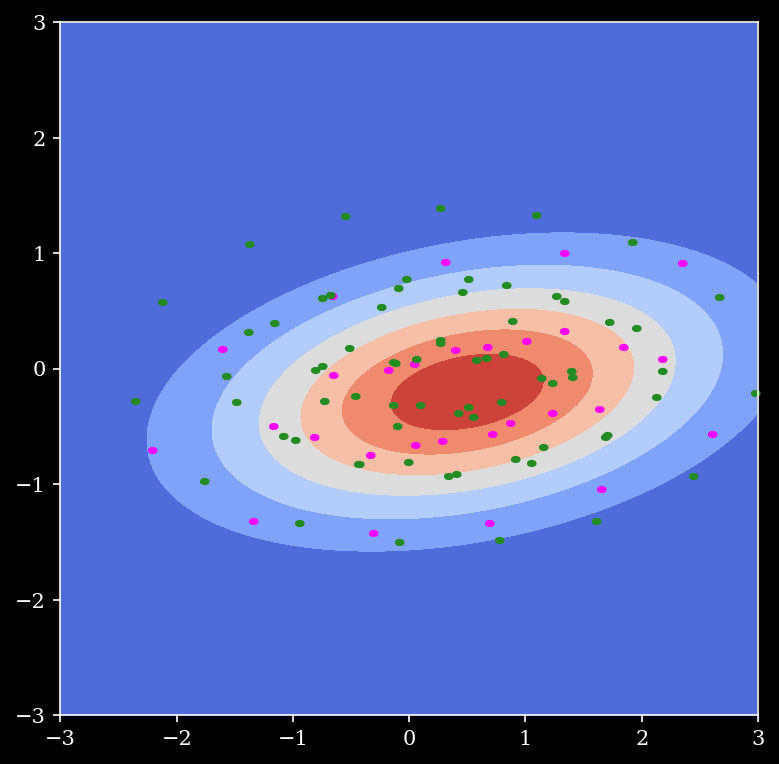

In [ ]:
x, y = np.mgrid[-3:3:.01, -3:3:.01]
pos = np.dstack((x, y))

fig2 = plt.figure(figsize=(6, 6))
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y,
             rv.pdf(pos),
             cmap='coolwarm')

marker_symbol = u'\u2B2C'

# Scatter initial particles
ax2.scatter(post_particles_hf[:, 0, -1], post_particles_hf[:, 1, -1],
            color="magenta",
            marker="$%s$" % marker_symbol,
            s=15,
            clip_on=False,
            label="HF")

ax2.scatter(post_particles_lf[:, 0, -1], post_particles_lf[:, 1, -1],
            color="forestgreen",
            marker="$%s$" % marker_symbol,
            s=15,
            clip_on=False,
            label="LF")

ax2.set_xlim(-3, 3)
ax2.set_ylim(-3, 3)

Text(0, 0.5, 'lengthscale')

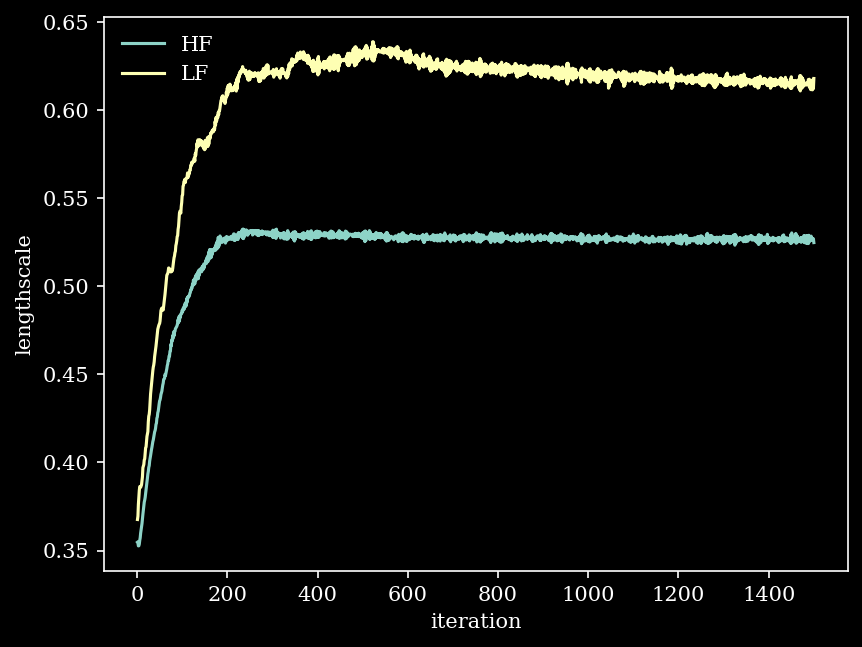

In [ ]:
plt.plot(np.linspace(1, n_iters, n_iters), lengthscales_all_hf, label="HF")
plt.plot(np.linspace(1, n_iters, n_iters), lengthscales_all_lf, label="LF")
plt.legend()
plt.xlabel("iteration")
plt.ylabel("lengthscale")

(-3.0, 3.0)

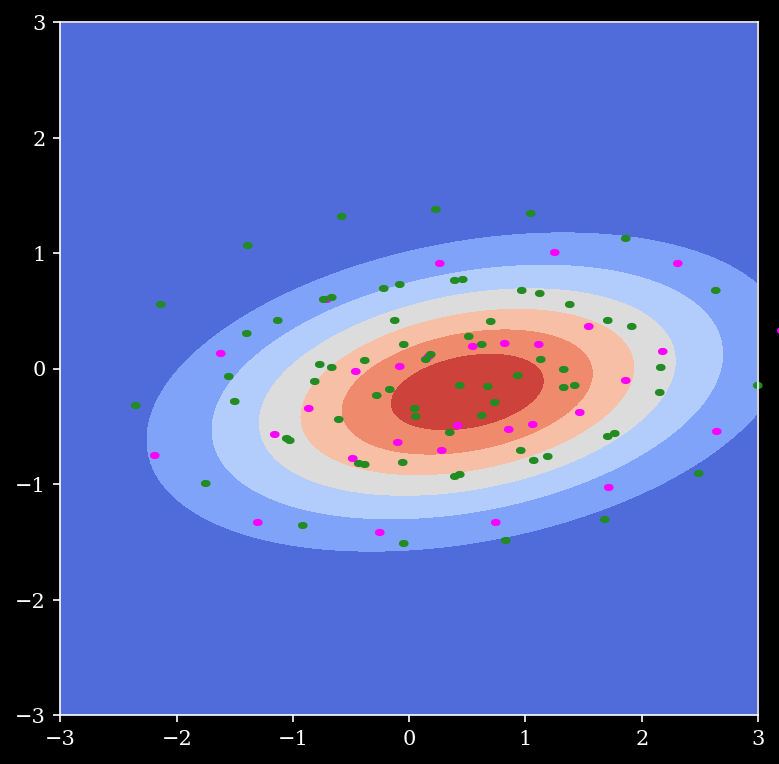

In [97]:
x, y = np.mgrid[-3:3:.01, -3:3:.01]
pos = np.dstack((x, y))

fig2 = plt.figure(figsize=(6, 6))
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y,
             rv.pdf(pos),
             cmap='coolwarm')

marker_symbol = u'\u2B2C'

# Scatter initial particles
ax2.scatter(post_particles_hf_correct[:, 0, -1], post_particles_hf_correct[:, 1, -1],
            color="magenta",
            marker="$%s$" % marker_symbol,
            s=15,
            clip_on=False,
            label="HF")

ax2.scatter(post_particles_lf_correct[:, 0, -1], post_particles_lf_correct[:, 1, -1],
            color="forestgreen",
            marker="$%s$" % marker_symbol,
            s=15,
            clip_on=False,
            label="LF")

ax2.set_xlim(-3, 3)
ax2.set_ylim(-3, 3)

Text(0, 0.5, 'lengthscale')

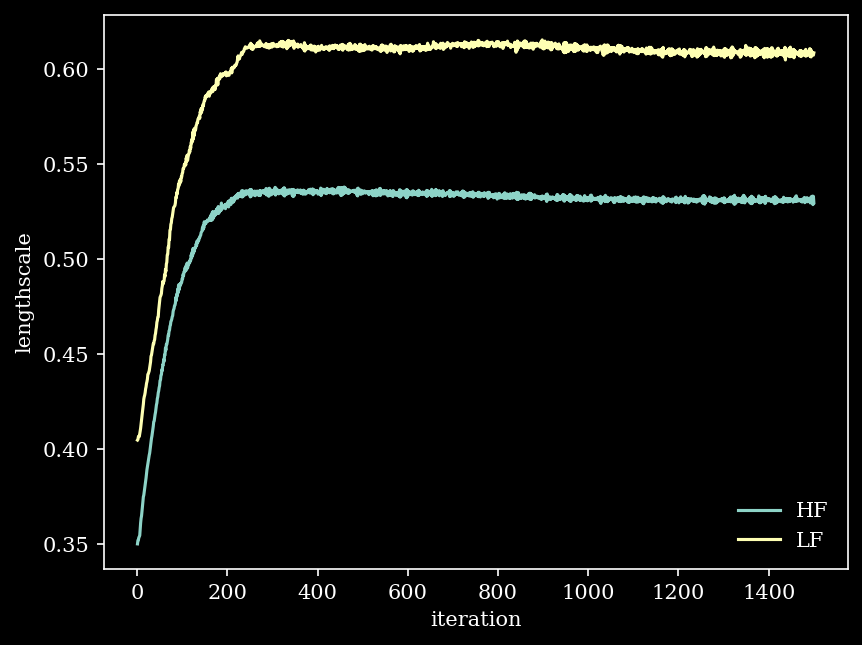

In [98]:
plt.plot(np.linspace(1, n_iters, n_iters), lengthscales_all_hf, label="HF")
plt.plot(np.linspace(1, n_iters, n_iters), lengthscales_all_lf, label="LF")
plt.legend()
plt.xlabel("iteration")
plt.ylabel("lengthscale")

In [ ]:
!pip install --quiet celluloid

In [ ]:
import os
os.makedirs("particle_animations", exist_ok=True)
import sys

In [ ]:
from IPython.display import HTML
from celluloid import Camera
from matplotlib.animation import FuncAnimation
from rich.progress import track
fig = plt.figure(figsize=(6, 6))
camera = Camera(fig)
marker_symbol = u'\u2B2C'

for i in track(range(post_particles_hf.shape[2] + 1), description="Processing particles at step ..."):
  # Step through and save a few frames only.
  # for i in range(11):
  t = plt.contourf(x, y,
             rv.pdf(pos),
             cmap='coolwarm')


  # Scatter initial particles
  if i == 0:
    particles_to_show_lf = initial_particles_lf
    particles_to_show_hf = initial_particles_hf
  else:
    particles_to_show_lf = post_particles_lf[:, :, i - 1]
    particles_to_show_hf = post_particles_hf[:, :, i - 1]


  plt.scatter(particles_to_show_lf[:, 0], particles_to_show_lf[:, 1],
            color="magenta",
            marker="$%s$" % marker_symbol,
            s=15,
            clip_on=False,
            label="LF")

  plt.scatter(particles_to_show_hf[:, 0], particles_to_show_hf[:, 1],
            color="forestgreen",
            marker="$%s$" % marker_symbol,
            s=15,
            clip_on=False,
            label="HF")


  plt.xlim(-3, 3)
  plt.ylim(-3, 3)

  plt.savefig(os.path.join("./particle_animations", "particles_iter_{:04d}.png".format(i)), dpi=150)
  plt.close()

  camera.snap()

animation = camera.animate()
HTML(animation.to_html5_video())
animation.save('mvn_particles_bifidelity_fixed.gif', writer='pillow')

Output()

In [ ]:
x02 = np.random.normal(0,1,[3,2])
x02.shape

sq_dist = pdist(x02)
pairwise_dists = squareform(sq_dist)**2
h = np.median(pairwise_dists)
h = np.sqrt(0.5 * h / np.log(x02.shape[0]+1))
Kxy = np.exp( -pairwise_dists / h**2 / 2)
Kxy.shape

In [ ]:
sq_dist.shape, pairwise_dists.shape

In [ ]:
Kxy

In [ ]:
dxkxy = -np.matmul(Kxy, x02)
sumkxy = np.sum(Kxy, axis=1)
sumkxy.shape, dxkxy.shape

In [ ]:
np.multiply(x02[:, 0], sumkxy)

Torch based implementation examples

In [ ]:
# Low-level RBF:
# def svgd_kernel(self, theta, h = -1):
#     sq_dist = pdist(theta)
#     pairwise_dists = squareform(sq_dist)**2
#     if h < 0: # if h < 0, using median trick
#         h = np.median(pairwise_dists)
#         h = np.sqrt(0.5 * h / np.log(theta.shape[0]+1))

#     # compute the rbf kernel
#     Kxy = np.exp( -pairwise_dists / h**2 / 2)

#     dxkxy = -np.matmul(Kxy, theta)
#     sumkxy = np.sum(Kxy, axis=1)
#     for i in range(theta.shape[1]):
#         dxkxy[:, i] = dxkxy[:,i] + np.multiply(theta[:,i],sumkxy)
#     dxkxy = dxkxy / (h**2)
#     return (Kxy, dxkxy)

# class RBF(torch.nn.Module):
#   def __init__(self, sigma=None):
#     super(RBF, self).__init__()

#     self.sigma = sigma

#   def forward(self, X, Y):
#     XX = X.matmul(X.t())
#     XY = X.matmul(Y.t())
#     YY = Y.matmul(Y.t())

#     dnorm2 = -2 * XY + XX.diag().unsqueeze(1) + YY.diag().unsqueeze(0)

#     # Apply the median heuristic (PyTorch does not give true median)
#     if self.sigma is None:
#       np_dnorm2 = dnorm2.detach().cpu().numpy()
#       h = np.median(np_dnorm2) / (2 * np.log(X.size(0) + 1))
#       sigma = np.sqrt(h).item()
#     else:
#       sigma = self.sigma

#     gamma = 1.0 / (1e-8 + 2 * sigma ** 2)
#     K_XY = (-gamma * dnorm2).exp()

#     return K_XY

# # Let us initialize a reusable instance right away.
# K = RBF()

In [ ]:
# import torch
# import torch.autograd as autograd
# import torch.optim as optim
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# class SVGD_torch:
#   """
#   Less low level implementation using torch autograd - see https://sanyamkapoor.com/kb/the-stein-gradient/
#   """
#   def __init__(self, P, K, optimizer):
#     self.P = P
#     self.K = K
#     self.optim = optimizer

#   def phi(self, X):
#     X = X.detach().requires_grad_(True)

#     log_prob = self.P.log_prob(X)
#     score_func = autograd.grad(log_prob.sum(), X)[0]

#     K_XX = self.K(X, X.detach())
#     grad_K = -autograd.grad(K_XX.sum(), X)[0]

#     phi = (K_XX.detach().matmul(score_func) + grad_K) / X.size(0)

#     return phi


#   def step(self, X):
#     self.optim.zero_grad()
#     X.grad = -self.phi(X)
#     self.optim.step()
#     # save all intermediate Xs


In [ ]:
rv_torch = torch.distributions.MultivariateNormal(torch.Tensor(mu_oracle).to(device),
        covariance_matrix=torch.Tensor(cov_oracle).to(device))

In [ ]:
init_particles_torch = torch.Tensor(initial_particles).to(device)
init_particles_torch.shape

In [ ]:
(init_particles_torch[:, None] - init_particles_torch).shape

In [ ]:
torch.norm(init_particles_torch[:, None] - init_particles_torch, dim=2, p=2).shape

In [ ]:
torch.sum(torch.isclose(torch.norm(init_particles_torch[:, None] - init_particles_torch, dim=2, p=2), torch.Tensor(squareform(pdist(initial_particles))))) # nice!!!!!!

In [ ]:
squareform(pdist(initial_particles))

In [ ]:
# torch.nn.PairwiseDistance(p=2)(init_particles_torch, init_particles_torch)

In [ ]:
import torch
import torch.autograd as autograd
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SVGD_torch_custom:
  """
  Less low level implementation using torch autograd - see https://sanyamkapoor.com/kb/the-stein-gradient/
  """
  def __init__(self, P, optimizer, ls=None):
    self.P = P
    # self.K = K
    self.optim = optimizer
    if ls is None:
      self.h=-1
    else:
      self.h = nn.Parameter(torch.randn(1))


  def svgd_kernel(self, X1, X2):
    pairwise_dists = torch.norm(init_particles_torch[:, None] - init_particles_torch, dim=2, p=2)

    # compute lengthscale
    if self.h == -1:
      h = np.median(pairwise_dists)
      h = np.sqrt(0.5 * h / np.log(theta.shape[0]+1))
    else:
      h = self.h

    K_XY = torch.exp( -pairwise_dists / h**2 / 2)

    return K_XY, lengthscale


  def phi(self, X):
    X = X.detach().requires_grad_(True)

    log_prob = self.P.log_prob(X)
    lnpgrad = autograd.grad(log_prob.sum(), X)[0]

    K_XX, lengthscale = self.svgd_kernel(X, X.detach())
    dxkxy = -autograd.grad(K_XX.sum(), X)[0]

    phi = (K_XX.detach().matmul(lnpgrad) + dxkxy) / X.size(0)

    return phi

  def step(self, X):
    self.optim.zero_grad()
    X.grad = -self.phi(X)
    self.optim.step()
    # save all intermediate Xs

In [ ]:
# !pip install --quiet celluloid
# from celluloid import Camera
# from matplotlib.animation import FuncAnimation

In [ ]:
# jupyter fix?
from IPython.display import HTML
# animation = camera.animate()
# HTML(animation.to_html5_video())

In [ ]:
import os
# os.makedirs("particle_animations", exist_ok=True)

In [ ]:
# from rich.progress import track
# fig = plt.figure(figsize=(6, 6))
# # camera = Camera(fig)
# marker_symbol = u'\u2B2C'

# for i in track(range(post_particles_all.shape[2] + 1), description="Processing particles at step ..."):
#   # Step through and save a few frames only.
#   # for i in range(11):
#   t = plt.contourf(x, y,
#              rv.pdf(pos),
#              cmap='coolwarm')


#   # Scatter initial particles
#   if i == 0:
#     particles_to_show = initial_particles
#   else:
#     particles_to_show = post_particles_all[:, :, i - 1]


#   plt.scatter(particles_to_show[:, 0], particles_to_show[:, 1],
#             color="white",
#             marker="$%s$" % marker_symbol,
#             s=15,
#             clip_on=False)


#   plt.xlim(-3, 3)
#   plt.ylim(-3, 3)

#   plt.savefig(os.path.join("./particle_animations", "particles_iter_{:04d}.png".format(i)), dpi=150)
#   plt.close()

#   camera.snap()

# animation = camera.animate()
# HTML(animation.to_html5_video())
# animation.save('mvn_particles.gif', writer='pillow')

In [ ]:
from google.colab import files
import shutil

shutil.make_archive("particle_animations", 'zip', "particle_animations")
files.download("particle_animations.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

# from matplotlib import pyplot as plt
# from celluloid import Camera

# fig = plt.figure()
# camera = Camera(fig)
# for i in range(10):
#     plt.plot([i] * 10)
#     camera.snap()
# animation = camera.animate()
# HTML(animation.to_html5_video())

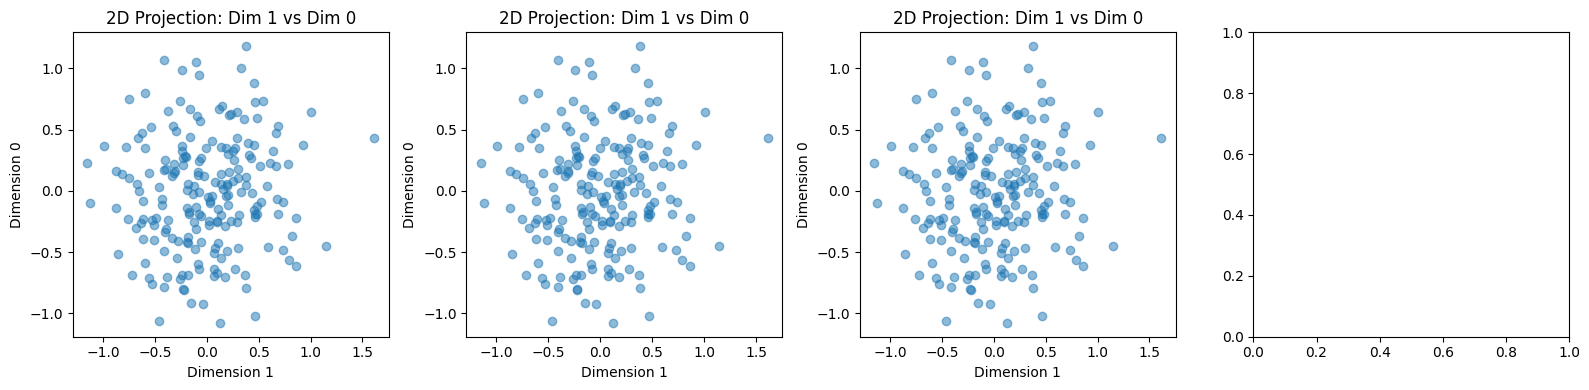

In [ ]:
# Need to fix!

import numpy as np
import sklearn
import sklearn.datasets
from sklearn.utils import shuffle as util_shuffle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Dataset iterator
def inf_train_gen(data, rng=None, batch_size=200, n_dim=20):
    if rng is None:
        rng = np.random.RandomState()

    if data == "8gaussians":
        scale = 0.5
        centers = [
            (1, 0), (-1, 0), (0, 1), (0, -1),
            (1. / np.sqrt(2), 1. / np.sqrt(2)),
            (1. / np.sqrt(2), -1. / np.sqrt(2)),
            (-1. / np.sqrt(2), 1. / np.sqrt(2)),
            (-1. / np.sqrt(2), -1. / np.sqrt(2))
        ]
        centers = [(scale * x, scale * y) + (0,) * (n_dim - 2) for x, y in centers]

        dataset = []
        for i in range(batch_size):
            point = rng.randn(n_dim) * 0.5
            idx = rng.randint(8)
            center = centers[idx]
            point += np.array(center)
            dataset.append(point)
        dataset = np.array(dataset, dtype="float32")
        dataset /= 1.414
        return dataset

def plot_8gaussians_projections(data, num_projections=3):
    """
    Plot projections of the multidimensional 8 Gaussians data.

    :param data: numpy array of shape (n_samples, n_dimensions)
    :param num_projections: number of 2D projections to plot
    """
    n_samples, n_dim = data.shape
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    # 2D projections
    for i, ax in zip(range(num_projections), axs):
        dim1, dim2 = np.random.choice(n_dim, 2, replace=False)
        # ax = fig.add_subplot(((num_projections + 2) // 3), 3, i+1)
        ax.scatter(data[:, dim1], data[:, dim2], alpha=0.5)
        ax.set_title(f'2D Projection: Dim {dim1} vs Dim {dim2}')
        ax.set_xlabel(f'Dimension {dim1}')
        ax.set_ylabel(f'Dimension {dim2}')

    # 3D projection
    # ax = fig.add_subplot(((num_projections + 2) // 3), 3, num_projections+1, projection='3d')
    if n_dim >= 3:
      dim1, dim2, dim3 = np.random.choice(n_dim, 3, replace=False)
      # change property of ax[-1] to accomodate 3d projection:
      axs[-1] = fig.add_subplot(1, 4, 4, projection='3d')
      axs[-1].scatter(data[:, dim1], data[:, dim2], data[:, dim3], alpha=0.5)
      axs[-1].set_title(f'3D Projection: Dim {dim1} vs Dim {dim2} vs Dim {dim3}')
      axs[-1].set_xlabel(f'Dimension {dim1}')
      axs[-1].set_ylabel(f'Dimension {dim2}')
      axs[-1].set_zlabel(f'Dimension {dim3}')

    plt.tight_layout()
    plt.show()


rng = np.random.RandomState(42)
toy_data = inf_train_gen("8gaussians", rng, batch_size=200, n_dim=2)
plot_8gaussians_projections(toy_data, num_projections=3)

In [ ]:
# Simple way to use Custom Markers (thanks StackOverflow - https://stackoverflow.com/a/15883684)

# from numpy import *
# import matplotlib.pyplot as plt

# symbols = [u'\u2B21',
#            u'\u263A',
#            u'\u29C6',
#            u'\u2B14',
#            u'\u2B1A',
#            u'\u25A6',
#            u'\u229E',
#            u'\u22A0',
#            u'\u22A1',
#            u'\u20DF',
#            u'\u2B2C']

# x = arange(10.)
# y = arange(10.)

# plt.figure()
# for i, symbol in enumerate(symbols):
#     y2 = y + 4*i
#     plt.plot(x, y2, 'g')
#     marker = "$%s$" % symbol
#     print(marker)
#     plt.plot(x, y2, 'k', marker=marker, markersize=30)